In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import geopandas as gpd
import pandas as pd
import glob
import zipfile
import rasterio
import os
import xarray as xr
import json
from rasterstats import zonal_stats
from rasterio.transform import from_origin


# gpd.version.version

Populating the interactive namespace from numpy and matplotlib


C:\Users\rmcd\anaconda3\envs\gridmet_4\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\rmcd\anaconda3\envs\gridmet_4\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# Open Gridmet max temperature with geopandas and plot

0 nhru_01.zip
1 nhru_02.zip
nhru_02.shp
     POI_ID  hru_id_nat  hru_id_reg region  \
0  10054896        2463           1     02   
1  10054896        2464           2     02   
2  10054884        2465           3     02   
3  10054884        2466           4     02   
4   8526515        2467           5     02   

                                            geometry  
0  POLYGON ((-76.58883845899999 36.74653056200003...  
1  (POLYGON ((-76.46904191499993 36.7791440250000...  
2  POLYGON ((-76.65698387399993 36.85365225800007...  
3  POLYGON ((-76.62364401799994 36.86489843200007...  
4  POLYGON ((-79.99363256999999 37.44257329500005...  


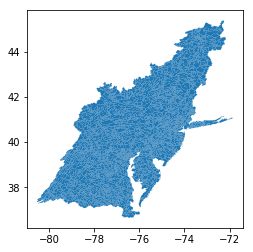

In [2]:
directory = r'C:\Users\rmcd\Documents\oNHM\GeospatialFabric_1\nhru'
unzip_dir = r'C:\Users\rmcd\Documents\oNHM\GeospatialFabric_1\nhru\unzip'
os.chdir(directory)
# filenames = glob.glob('*_[0-1]*.zip')
for idx, name in enumerate(glob.glob('*_[0-1]*.zip')):
    print(idx, name)
    if idx == 1: # for testing we just open the second file
        #unzip file
        zip_ref = zipfile.ZipFile(name, 'r')
        zip_ref.extractall(unzip_dir)
        zip_ref.close()
        (prefix, sep, suffix) = name.rpartition('.')
        shp_name = prefix+r'.shp'
        os.chdir(unzip_dir)
        print(shp_name)
        data = gpd.read_file(shp_name)
        print(data.head())
        break
data.plot()

# Open Gridmet data (as netcdf file) and save as geotiff raster
This first bit of code follows examples from the following link:https://climate.northwestknowledge.net/MACA/OPENDAP.php
First we open the data set and inspect the metadata

In [3]:
#=========================================================
#            MACAV2METDATA FILE PARAMETERS
#=========================================================
dirPath='http://thredds.northwestknowledge.net:8080'
fileName='/thredds/dodsC/MET/tmmx/tmmx_2019.nc'

#--------------------------------------------------------
#   FORM FILENAME AND GET HANDLE TO FILE AND DATA
#--------------------------------------------------------
fullfilename= dirPath+fileName
print(fullfilename)

ds = xr.open_dataset(fullfilename)

print(ds)

# df = ds.to_dataframe()

print('\n The meta data is: \n', json.dumps(ds.attrs, indent=4))
lathandle=ds['lat']
lonhandle=ds['lon']
timehandle=ds['day']
datahandle=ds['air_temperature']
crshandle=ds['crs']
print('\n The crs meta data is \n', json.dumps(crshandle.attrs, indent=4))

# crstransform = crshandle.attrs['GeoTransform']
# print(crstransform)

#collect data to describe geotransform
lonmin = float(ds.attrs['geospatial_lon_min'])
latmax = float(ds.attrs['geospatial_lat_max'])
lonres = float(ds.attrs['geospatial_lon_resolution'])
latres = float(ds.attrs['geospatial_lon_resolution'])

#Print some information on the data

print('\n Data attributes, sizes, and coords \n') 
print('\n Data attributes are: \n', json.dumps(datahandle.attrs, indent=4))
print('\n Data sizes are: \n', datahandle.sizes)
print('\n Data coords are: \n', datahandle.coords)


ts = datahandle.sizes
print(type(ts))
print(ts['day'])
dayshape = ts['day']
Lonshape = ts['lon']
Latshape = ts['lat']
#dayshape,lonshape,latshape = datahandle.values.shape
print(dayshape, Lonshape, Latshape)


# datahandle.values[dayshape-1,:,:].shape

# print(lathandle.values.shape)
# print(type(lathandle.values))
# print(datahandle.dtype)
# print(np.isfortran(datahandle.values))

http://thredds.northwestknowledge.net:8080/thredds/dodsC/MET/tmmx/tmmx_2019.nc
<xarray.Dataset>
Dimensions:          (crs: 1, day: 110, lat: 585, lon: 1386)
Coordinates:
  * lon              (lon) float64 -124.8 -124.7 -124.7 ... -67.14 -67.1 -67.06
  * lat              (lat) float64 25.07 25.11 25.15 25.19 ... 49.32 49.36 49.4
  * day              (day) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-04-20
  * crs              (crs) int32 1
Data variables:
    air_temperature  (day, lat, lon) float32 ...
Attributes:
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    geospatial_lon_max:         -67.058333300000015
    geospatial_lon_resolution:  0.041666666666666
    geospatial_lat_resolution:  0.041666666666666
    geospatia

# Convert netcdf to geotiff

In [7]:
lat = lathandle.values
lon = lonhandle.values

transform = from_origin( lonmin, latmax, lonres, latres)
# res = (lon[-1] - lon[0])/lon.shape[0]
# print(res)
# transform2 = from_origin(lon[0]-res/2, lat[-1]+res/2, res, res) 
# print(transform, transform2)
print(transform)
new_dataset = rasterio.open(r'C:\Users\rmcd\Documents\oNHM\GeospatialFabric_1\nhru\unzip\test1.tif', 'w', driver='GTiff',
                            height = Lonshape, width = Latshape,
                            count=1, dtype=str(datahandle.dtype),
                            crs={'init': 'epsg:4326'},
                            transform=transform)
# vals = np.transpose(datahandle.values, [1,2,0])
# vals2 = vals[:,:,85-1]
vals = datahandle.values[dayshape-1, :, :]
print(vals.shape)
# im = np.transpose(vals, [1,2,0])
# fa = np.asfortranarray(vals)
# ca = np.asanyarray(vals, order='C')
ud = (np.flipud(vals)-273.15) * 9/5 + 32
# at = np.transpose(vals)
# atf = np.rot90(at)
new_dataset.write(ud, 1)
# new_dataset.warp.transform
# print(new_dataset.transform)
# pyplot.imshow(new_dataset.read(1), cmap='pink')
# pyplot.show()
print(new_dataset)
new_dataset.close()

| 0.04, 0.00,-124.77|
| 0.00,-0.04, 49.40|
| 0.00, 0.00, 1.00|
(585, 1386)
<open DatasetWriter name='C:\Users\rmcd\Documents\oNHM\GeospatialFabric_1\nhru\unzip\test1.tif' mode='w'>


# Plot geotiff raster data

<class 'affine.Affine'> {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 585, 'height': 1386, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.041666666666666, 0.0, -124.7666666333333,
       0.0, -0.041666666666666, 49.4)}
<closed DatasetReader name='test1.tif' mode='r'>


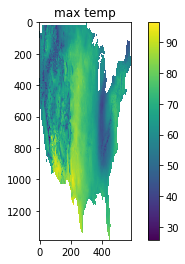

In [8]:
os.chdir(r'C:\Users\rmcd\Documents\oNHM\GeospatialFabric_1\nhru\unzip')
with rasterio.open(r'test1.tif') as src:
    transform = src.meta['transform']
    print(type(transform), src.meta)
    array = src.read(1)
print(src)
plt.imshow(array, interpolation='nearest')
plt.colorbar()
plt.title('max temp')
plt.show()
src.close()

# Perform zonal stats using rasterstats with the geotiff raster and hru shapefile

| 0.04, 0.00,-124.77|
| 0.00,-0.04, 49.40|
| 0.00, 0.00, 1.00|
<class 'affine.Affine'> {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1386, 'height': 585, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.041666666666666, 0.0, -124.7666666333333,
       0.0, -0.041666666666666, 49.4)}


C:\Users\rmcd\anaconda3\envs\gridmet_4\lib\site-packages\rasterstats\io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


   tmax_count   tmax_max  tmax_mean   tmax_min
0           4  75.062943  74.983322  74.829544
1          15  75.324142  74.910474  74.426178
2          11  76.526161  75.966092  74.995651
3           6  76.006180  75.546097  74.995651
4           4  73.736679  73.255928  72.783669


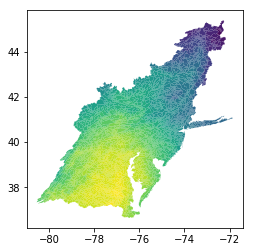

In [6]:
import geoplot as gplt

print(transform)
with rasterio.open(r'test1.tif') as src:
    transform = src.meta['transform']
    print(type(transform), src.meta)
    array = src.read(1)

hrudata = gpd.GeoDataFrame.from_file(r'nhru_02.shp')

stats = zonal_stats(hrudata, array, transform=transform.to_gdal(), prefix='tmax_', all_touched=True)
statsdf = pd.DataFrame(stats)
src.close()

print(statsdf.head())

zonalhru = hrudata.join(statsdf)

# # print(stats)
# # newhru = hrudata.join(gpd.DataFrame(stats))
# # print(newhru.head())
zonalhru.__class__ = gpd.GeoDataFrame
zonalhru.crs={}
zonalhru.set_geometry('geometry')
# ax = gplt.pointplot(zonalhru['mean'])
# gplt.polyplot()
# geoplot.choropleth(zonalhru, hue='mean', cmap='viridis', k = 20, 
#                 linewidth=0.5, legend=True)
zonalhru.plot(column='tmax_mean', cmap='viridis')

# Alternative Rasterstats method: 
* https://geohackweek.github.io/vector/06-geopandas-advanced/

<class 'affine.Affine'> {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1386, 'height': 585, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.041666666666666, 0.0, -124.7666666333333,
       0.0, -0.041666666666666, 49.4)}


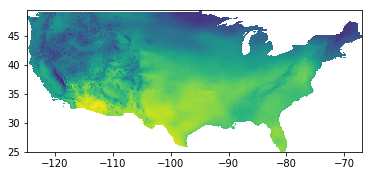

<bound method _AxesBase.axis of <matplotlib.axes._subplots.AxesSubplot object at 0x000001BEAAEE3710>>
     POI_ID                                           geometry  hru_id_nat  \
0  10054896  POLYGON ((-76.58883845899999 36.74653056200003...        2463   
1  10054896  (POLYGON ((-76.46904191499993 36.7791440250000...        2464   
2  10054884  POLYGON ((-76.65698387399993 36.85365225800007...        2465   
3  10054884  POLYGON ((-76.62364401799994 36.86489843200007...        2466   
4   8526515  POLYGON ((-79.99363256999999 37.44257329500005...        2467   

   hru_id_reg region  tmax_count   tmax_max  tmax_mean   tmax_min  
0           1     02           4  75.062943  74.983322  74.829544  
1           2     02          15  75.324142  74.910474  74.426178  
2           3     02          11  76.526161  75.966092  74.995651  
3           4     02           6  76.006180  75.546102  74.995651  
4           5     02           4  73.736679  73.255920  72.783669  


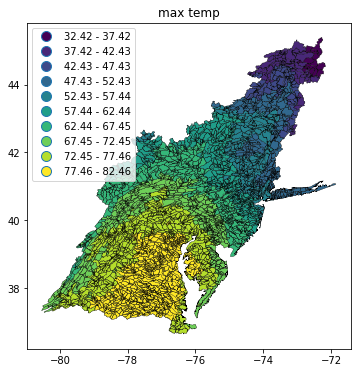

In [7]:
import rasterio
import rasterio.plot as rioplot
import cartopy.crs as ccrs

# print(transform)
with rasterio.open(r'test1.tif') as src:
    transformb = src.meta['transform']
    print(type(transformb), src.meta)
    array = src.read(1)
rasterdata = rasterio.open(r'test1.tif')
tmp = rioplot.show(rasterdata, with_bounds=True, cmap='viridis', extent=([-82, -70, 36, 46]))
print(tmp.axis)
tmp.set_xlim([-82, -70])
tmp.set_ylim([36, 46])
hrudata = gpd.GeoDataFrame.from_file(r'nhru_02.shp')

stats = zonal_stats(hrudata, r'test1.tif', transform=transformb.to_gdal(), prefix='tmax_', 
                    all_touched=True, geojson_out=True)
# statsdf = pd.DataFrame(stats)
# src.close()
stats_gdf = gpd.GeoDataFrame.from_features(stats)
print(stats_gdf.head())
extent=([-82, -70, 36, 46])
f, ax = plt.subplots(1, figsize=(8,6))
ax.set_title("max temp")
stats_gdf.plot(ax=ax, column='tmax_mean', scheme='Equal_Interval', k=10, 
                   cmap='viridis', linewidth=0.25, edgecolor='black', 
                   legend=True, legend_kwds={'loc': 'upper left'})

# Alternative Rasterstats by opening netcdf directly rather than first saving to geotif

In [11]:
import rasterio
import rasterio.plot as rioplot
import cartopy.crs as ccrs

print(os.getcwd())
with rasterio.open(r'../Data/new.nc', driver='NetCDF') as src:
    transformb = src.meta['transform']
    print(type(transformb), src.meta)
    array = src.read(1)
rasterdata = rasterio.open(r'test1.tif')
tmp = rioplot.show(rasterdata, with_bounds=True, cmap='viridis', extent=([-82, -70, 36, 46]))
print(tmp.axis)
tmp.set_xlim([-82, -70])
tmp.set_ylim([36, 46])
hrudata = gpd.GeoDataFrame.from_file(r'nhru_02.shp')

stats = zonal_stats(hrudata, r'test1.tif', transform=transformb.to_gdal(), prefix='tmax_', 
                    all_touched=True, geojson_out=True)
# statsdf = pd.DataFrame(stats)
# src.close()
stats_gdf = gpd.GeoDataFrame.from_features(stats)
print(stats_gdf.head())
extent=([-82, -70, 36, 46])
f, ax = plt.subplots(1, figsize=(8,6))
ax.set_title("max temp")
stats_gdf.plot(ax=ax, column='tmax_mean', scheme='Equal_Interval', k=10, 
                   cmap='viridis', linewidth=0.25, edgecolor='black', 
                   legend=True, legend_kwds={'loc': 'upper left'})

C:\Users\rmcd\Documents\oNHM\GeospatialFabric_1\nhru\unzip


RasterioIOError: ../Data/new.nc: No such file or directory

In [8]:
print(len(stats_gdf.index))

4827


# write netcdf file using netcdf4
* https://github.com/Unidata/netcdf4-python/blob/master/examples/writing_netCDF.ipynb

In [10]:
import netCDF4
try: ncfile.close() # just to be safe, make sure dataset is not already open.
except: pass
ncfile = netCDF4.Dataset('new.nc',mode='w',format='NETCDF4_CLASSIC')

# Global Attributes
ncfile.Conventions = 'CF-1.8'
ncfile.featureType = 'timeSeries'
ncfile.history = ''

sp_dim = len(stats_gdf.index)
hruid_dim = ncfile.createDimension('hruid', sp_dim)     # hru_id
time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
for dim in ncfile.dimensions.items():
    print(dim)

#Create Variables
time = ncfile.createVariable('time', np.int, ('time', ))
time.long_name = 'time'
time.standard_name = 'time'
time.units = 'days since '+'base_date'+' 00:00'+'time_zone'

hru = ncfile.createVariable('hruid', np.int, ('hruid', ))
hru.cf_role = 'timeseries_id'
hru.long_name = 'local model hru id'

lat = ncfile.createVariable('hru_lat', np.float32, ('hruid',))
lat.long_name = 'Latitude of HRU centroid'
lat.units = 'degrees_north'
lat.standard_name = 'hru_latitude'

lon = ncfile.createVariable('hru_lon', np.float32, ('hruid',))
lon.long_name = 'Longitude of HRU centroid'
lon.units = 'degrees_east'
lon.standard_name = 'hru_longitude'

prcp = ncfile.createVariable('prcp', np.float32, ('time', 'hruid'))
prcp.long_name = 'Daily precipitation rate'
prcp.units = 'mm/day'
prcp.standard_name = 'lwe_precipitation_rate'

tmax = ncfile.createVariable('tmax', np.float32, ('time', 'hruid'))
tmax.long_name = 'Maximum daily air temperature'
tmax.units = 'degree_Celsius'
tmax.standard_name = 'maximum_daily_air_temperature'

tmin = ncfile.createVariable('tmin', np.float32, ('time', 'hruid'))
tmin.long_name = 'Minimum daily air temperature'
tmin.units = 'degree_Celsius'
tmin.standard_name = 'minimum_daily_air_temperature'

# fill variables with available data
def getXY(pt):
    return (pt.x, pt.y)
centroidseries = stats_gdf['geometry'].centroid
tlon, tlat = [list(t) for t  in zip(*map(getXY, centroidseries))]
# print(lon, lat)
lon[:] = tlon
lat[:] = tlat
hru[:] = stats_gdf['hru_id_nat'].values
# print(hruid)
tmax[0,:] = stats_gdf['tmax_mean'].values

print(ncfile)
ncfile.close(); print("dataset is closed")


('hruid', <class 'netCDF4._netCDF4.Dimension'>: name = 'hruid', size = 4827
)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0
)
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.8
    featureType: timeSeries
    history: 
    dimensions(sizes): hruid(4827), time(1)
    variables(dimensions): int32 time(time), int32 hruid(hruid), float32 hru_lat(hruid), float32 hru_lon(hruid), float32 prcp(time,hruid), float32 tmax(time,hruid), float32 tmin(time,hruid)
    groups: 

dataset is closed
